<a href="https://www.kaggle.com/code/abdulaziz04/simple-approach-using-xgbclassifier?scriptVersionId=101229072" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # For Data Visualization
import xgboost as xgb
from xgboost import XGBClassifier,cv # Model to be used for classification
#and cv for cross_val

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option('max_rows',1000)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


The summary of the whole process can be explained as follows : 
1. Read the Dataset
2. Visualize and fill the missing values with a simple idea

    -> If the data has too many outliers, we take the median
    
    -> If the data appears to be normalized, we take the mean
    
    -> For categorical data, we usually take the mode
    
    Deleting the data is not an option as we have to provide a result for each given test case
3. Finalize the necessary features ( where we have considered the cabin portion by dviding it into three portions
4. Perform necessary encoduing ( one hot encoding for non-sequential categories and label encoding for sequential categories ) to prepare the data for training
5. Decide a model and tune hyperparameters to get the necessary results

In [2]:
#Read all datasets
sample=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
X=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
xtest=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
#Check for missing values
X.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
#Drop the unnecessary columns
xtrain=X.drop(['Name','PassengerId','Transported'],axis=1)
#Get the test ids
ids=xtest['PassengerId']
#Drop unnecessary columns in test dataset
xtest=xtest.drop(['Name','PassengerId'],axis=1)
#Target column for training dataset
y=X['Transported'].astype(int)

(array([ 591.,  649., 2089., 1976., 1350.,  893.,  536.,  294.,  106.,
          30.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

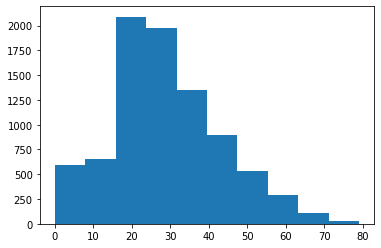

In [6]:
#Fill Age with mean
plt.hist(xtrain['Age'])

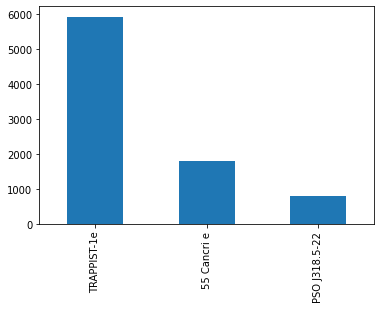

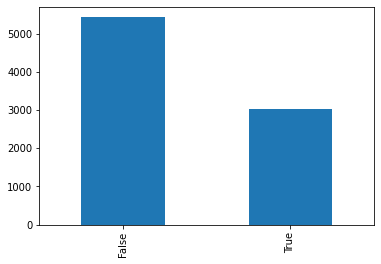

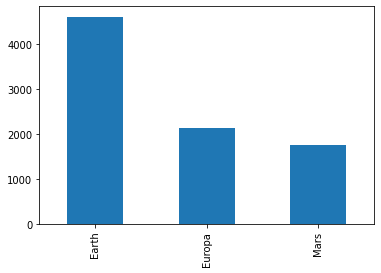

In [7]:
#Fill destination with mode
#Fill CryoSleep with mode
#Fill Cabin with hybrid mode
#Fill Homeplanet with mode
xtrain['Destination'].value_counts().plot(kind='bar')
plt.show()
xtrain['CryoSleep'].value_counts().plot(kind='bar')
plt.show()
#plt.figure(figsize=(10,10))
#xtrain['Cabin'].value_counts().plot(kind='bar')
#plt.show()
xtrain['HomePlanet'].value_counts().plot(kind='bar')
plt.show()

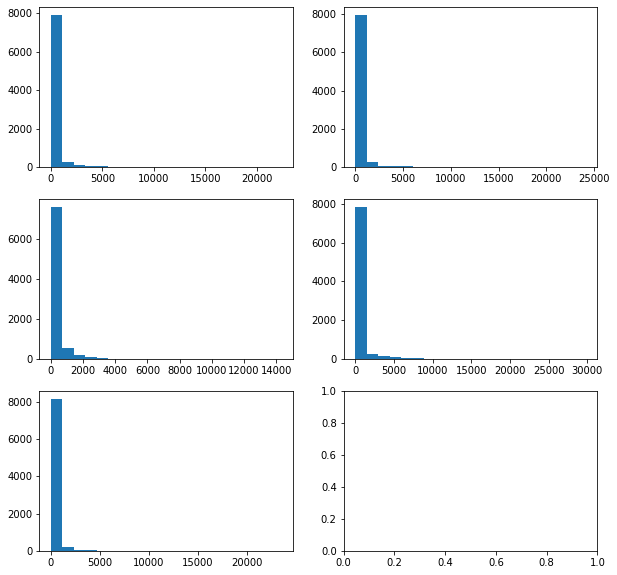

<AxesSubplot:>

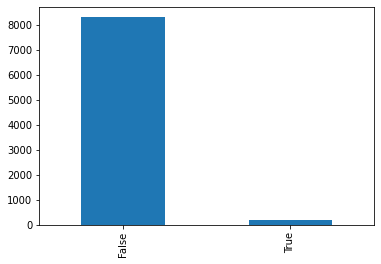

In [8]:
#Fill services columns with zero ie Mode
fig,axes=plt.subplots(3,2,figsize=(10,10))

axes[0][0].hist(xtrain['Spa'],bins=20)
axes[0][1].hist(xtrain['VRDeck'],bins=20)
axes[1][0].hist(xtrain['RoomService'],bins=20)
axes[1][1].hist(xtrain['FoodCourt'],bins=20)
axes[2][0].hist(xtrain['ShoppingMall'],bins=20)
plt.show()
#Drop the name column
#Fill VIP with False
xtrain['VIP'].value_counts().plot(kind='bar')



In [9]:
#Use the different portions of cabin to make a judgement : 
xtrain['Deck']=xtrain['Cabin'].apply(lambda x : str(x)[0])
xtrain['Num']=xtrain['Cabin'].apply(lambda x : str(x)[2])
xtrain['Side']=xtrain['Cabin'].apply(lambda x : str(x)[-1])

xtest['Deck']=xtest['Cabin'].apply(lambda x : str(x)[0])
xtest['Num']=xtest['Cabin'].apply(lambda x : str(x)[2])
xtest['Side']=xtest['Cabin'].apply(lambda x : str(x)[-1])
xtrain.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S


In [10]:
mode_cols=['Spa','VRDeck','ShoppingMall','FoodCourt','RoomService','VIP','Destination','CryoSleep','HomePlanet']
xtrain.fillna({col : xtrain[col].mode()[0] for col in mode_cols},inplace=True)
xtest.fillna({col : xtrain[col].mode()[0] for col in mode_cols},inplace=True)
xtrain.isnull().sum()

HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age             179
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Deck              0
Num               0
Side              0
dtype: int64

In [11]:
xtrain['Num'].replace('n',xtrain['Num'].mode()[0],inplace=True)
xtest['Num'].replace('n',xtrain['Num'].mode()[0],inplace=True)

xtrain['Side'].replace('n',xtrain['Side'].mode()[0],inplace=True)
xtest['Side'].replace('n',xtrain['Side'].mode()[0],inplace=True)

xtrain['Deck'].replace('n',xtrain['Num'].mode()[0],inplace=True)
xtest['Deck'].replace('n',xtrain['Num'].mode()[0],inplace=True)


In [12]:
#Convert booleans to ints
xtrain['VIP']=xtrain['VIP'].astype(bool).astype(int)
xtest['VIP']=xtest['VIP'].astype(bool).astype(int)
xtrain['CryoSleep']=xtrain['CryoSleep'].astype(bool).astype(int)
xtest['CryoSleep']=xtest['CryoSleep'].astype(bool).astype(int)

In [13]:
#Fill Age with mean
xtrain['Age'].fillna(xtrain['Age'].mean(),inplace=True)
xtest['Age'].fillna(xtrain['Age'].mean(),inplace=True)
xtrain.isnull().sum()

HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Deck              0
Num               0
Side              0
dtype: int64

In [14]:
xtest.isnull().sum()

HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Deck              0
Num               0
Side              0
dtype: int64

In [15]:
xtrain['Num']=xtrain['Num'].astype(int)
xtest['Num']=xtest['Num'].astype(int)

In [16]:
le=LabelEncoder()
ohe=OneHotEncoder(sparse=False)


In [17]:
def categorize(column,headers):
    le_result=le.fit_transform(column)
    le_result=le_result.reshape(len(column),1)
    ohe_result=pd.DataFrame(ohe.fit_transform(le_result),columns=headers)
    return ohe_result

In [18]:
#Get name of encoded columns to use in the final dataframe
destinations=sorted(xtrain['Destination'].unique())
homes=sorted(xtrain['HomePlanet'].unique())
decks=sorted(xtrain['Deck'].unique())
sides=sorted(xtrain['Side'].unique())


In [19]:
#Get one hot encoded results
ohe_train_destination=categorize(xtrain['Destination'],destinations)
ohe_train_home=categorize(xtrain['HomePlanet'],homes)
ohe_train_deck=categorize(xtrain['Deck'],decks)
ohe_train_side=categorize(xtrain['Side'],sides)
xtrain.head()


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,B,0,P
1,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,F,0,S
2,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,A,0,S
3,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,A,0,S
4,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,F,1,S


In [20]:
xtrain=xtrain.join([ohe_train_destination,ohe_train_home,ohe_train_deck,ohe_train_side])


In [21]:
xtrain.drop(['HomePlanet','Destination','Cabin','Deck','Side'],axis=1,inplace=True)

In [22]:
xtrain.isnull().sum()

CryoSleep        0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Num              0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
Earth            0
Europa           0
Mars             0
1                0
A                0
B                0
C                0
D                0
E                0
F                0
G                0
T                0
P                0
S                0
dtype: int64

In [23]:
#Same for Test dataset
ohe_test_destination=categorize(xtest['Destination'],destinations)
ohe_test_home=categorize(xtest['HomePlanet'],homes)
ohe_test_deck=categorize(xtest['Deck'],decks)
ohe_test_side=categorize(xtest['Side'],sides)

In [24]:
xtest=xtest.join([ohe_test_destination,ohe_test_home,ohe_test_deck,ohe_test_side])

In [25]:
xtest.drop(['HomePlanet','Destination','Cabin','Deck','Side'],axis=1,inplace=True)

In [26]:
xtest.isnull().sum()

CryoSleep        0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Num              0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
Earth            0
Europa           0
Mars             0
1                0
A                0
B                0
C                0
D                0
E                0
F                0
G                0
T                0
P                0
S                0
dtype: int64

In [27]:
xtrain

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,55 Cancri e,...,A,B,C,D,E,F,G,T,P,S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,9,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,6,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# XGB Classifier
params = {"objective":"binary:logistic",'colsample_bytree': 0.7,'learning_rate': 0.3,
                'max_depth': 20, 'alpha': 5,'eval_metric':'mlogloss'}
xgb_clf = XGBClassifier(**params)
print(xgb_clf)

XGBClassifier(alpha=5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss', gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, ...)


In [29]:
dmatrix = xgb.DMatrix(data=xtrain,label=y)
xgb_clf.fit(xtrain,y)
print(f'Training Score : {xgb_clf.score(xtrain,y):.2f}')

Training Score : 0.90


In [30]:
xgb_cv = cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=420)

In [31]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.848077,0.001299,0.822007,0.007182
1,0.883870,0.003190,0.857805,0.006336
2,0.898404,0.000549,0.869914,0.004296
3,0.906733,0.001320,0.874870,0.003534
4,0.911216,0.001261,0.878479,0.004188


<Figure size 1152x1152 with 0 Axes>

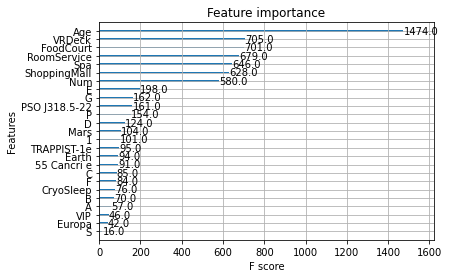

In [32]:
plt.figure(figsize = (16, 16))
xgb.plot_importance(xgb_clf)
plt.show()

In [33]:
results=xgb_clf.predict(xtest)
results=results.astype(bool)

In [34]:
final_df=pd.DataFrame({'Passengerid':ids,'Transported':results})
final_df.to_csv('submission.csv',index=False)